In [1150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

In [1151]:
# read in date as date then x.xdays x.year 
reviews = pd.read_csv('/Users/olivia/Desktop/Alexa Reviews/data/amazon_alexa.tsv',delimiter='\t', encoding="utf-8")

In [1152]:
reviews = reviews[['rating','verified_reviews']]

In [1153]:
len(reviews[reviews['rating']==5])/len(reviews)

0.7257142857142858

In [1154]:
reviews.count()

rating              3150
verified_reviews    3150
dtype: int64

In [1155]:
index = 5
print(reviews.verified_reviews[index], reviews.rating[index])

I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. 5


In [1237]:
stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)
stop_words.update('’')
stop_words.update('“')
stop_words.update('”')
stop_words

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [1224]:
# Removing URL's
def remove_URL(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(s):
    words = str(s).lower()
    words = word_tokenize(words)
    return [w for w in words if not w in stop_words]

#lemmatization
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_tokens(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(sentence)  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(WordNetLemmatizer().lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        u"\U0001F913"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [1231]:
#Removing the noisy text
def denoise_text(text):
    text = [remove_URL(x) for x in text] # input sentences(string), not tokens
    text = [remove_emoji(x) for x in text]
    text = [remove_stopwords(x) for x in text]
    text = [lemmatize_tokens(x) for x in text]
    return text

In [1232]:
corpus = denoise_text(reviews.verified_reviews)

In [1233]:
corpus

['love echo',
 'love',
 'sometimes play game answer question correctly alexa say get wrong answer like able turn light away home',
 'lot fun thing 4 yr old learn dinosaur control light play game like category nice sound playing music well',
 'music',
 'receive echo gift need another bluetooth something play music easily accessible find smart speaker wait see else',
 'without cellphone use many feature ipad see use great alarm u r almost deaf hear alarm bedroom living room reason enough keep her.it fun ask random question hear response seem smartbon politics yet',
 "think 5th one 've purchase 'm work get one every room house really like feature offer specifily play music echo control light throughout house",
 'look great',
 'love listen song hear since childhood get news weather information great',
 'sent 85 year old dad talk constantly',
 "love learn knew thing eveyday still figure everything work far 's easy use understand make laugh time",
 'purchase mother knee problem give somethin

In [1238]:
maxLen = len(max(reviews_denoise,key=len))
maxLen

290

In [1240]:
X_train, X_test, Y_train, Y_test = train_test_split(corpus, pd.DataFrame(reviews['rating']), test_size=0.2, random_state=3)

In [ ]:
#Bag of words - MultinomialNB (notes: no PCA, MultinomialNB takes discrete values)

In [1265]:
wordfreq = {}
for sentence in X_train:
    for token in word_tokenize(sentence):
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [1266]:
import math

In [1268]:
mostfreq = math.floor(len(wordfreq)*0.1)
mostfreq

327

In [1270]:
import heapq

In [1271]:
most_freq = heapq.nlargest(mostfreq, wordfreq, key=wordfreq.get)

In [1273]:
X_train_BOW = []
for sentence in X_train:
    sent_vec = []
    for token in most_freq:
        if token in word_tokenize(sentence):
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    X_train_BOW.append(sent_vec)
    
X_test_BOW = []
for sentence in X_test:
    sent_vec = []
    for token in most_freq:
        if token in word_tokenize(sentence):
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    X_test_BOW.append(sent_vec)

In [1274]:
X_train_BOW = np.asarray(X_train_BOW)
X_test_BOW = np.asarray(X_test_BOW)

In [1275]:
def convert_to_one_hot(Y, C):
    targets = np.array(Y).reshape(-1)
    one_hot_targets = np.eye(C)[targets-1]
    return one_hot_targets

In [1276]:
Y_train_oh = convert_to_one_hot(Y_train,5)

In [1277]:
Y_test_oh = convert_to_one_hot(Y_test,5)

In [1278]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV 

In [1279]:
np.random.seed(999)

nb_classifier = MultinomialNB()

params_NB = {'alpha': np.logspace(0,-9, num=100)}

mt_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=10,
                     verbose=2, 
                     refit = True,
                     scoring='accuracy')

mt_NB.fit(X_train_BOW, Y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.1s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConve

[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=0.8111308307896871 ........................................
[CV] ......................... alpha=0.8111308307896871, total=   0.0s
[CV] alpha=0.8111308307896871 ........................................
[CV] ......................... alpha=0.8111308307896871, total=   0.0s
[CV] alpha=0.8111308307896871 ........................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.657933224657568 .........................................
[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.657933224657568 .........................................
[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.657933224657568 .........................................
[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.657933224657568 .........................................
[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.657933224657568 .........................................
[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.657933224657568 .........................................
[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ......................... alpha=0.3511191734215131, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.15199110829529336 .......................................
[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.15199110829529336 .......................................
[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.15199110829529336 .......................................
[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.15199110829529336 .......................................
[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.15199110829529336 .......................................
[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.15199110829529336 .......................................
[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.15199110829529336 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.08111308307896872, total=   0.0s
[CV] alpha=0.08111308307896872 .......................................
[CV] ........................ alpha=0.08111308307896872, total=   0.0s
[CV] alpha=0.08111308307896872 .......................................
[CV] ........................ alpha=0.08111308307896872, total=   0.0s
[CV] alpha=0.08111308307896872 .......................................
[CV] ........................ alpha=0.08111308307896872, total=   0.0s
[CV] alpha=0.08111308307896872 .......................................
[CV] ........................ alpha=0.08111308307896872, total=   0.0s
[CV] alpha=0.08111308307896872 .......................................
[CV] ........................ alpha=0.08111308307896872, total=   0.0s
[CV] alpha=0.0657933224657568 ........................................
[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0657933224657568 ........................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.04328761281083057, total=   0.0s
[CV] alpha=0.04328761281083057 .......................................
[CV] ........................ alpha=0.04328761281083057, total=   0.0s
[CV] alpha=0.04328761281083057 .......................................
[CV] ........................ alpha=0.04328761281083057, total=   0.0s
[CV] alpha=0.03511191734215131 .......................................
[CV] ........................ alpha=0.03511191734215131, total=   0.0s
[CV] alpha=0.03511191734215131 .......................................
[CV] ........................ alpha=0.03511191734215131, total=   0.0s
[CV] alpha=0.03511191734215131 .......................................
[CV] ........................ alpha=0.03511191734215131, total=   0.0s
[CV] alpha=0.03511191734215131 .......................................
[CV] ........................ alpha=0.03511191734215131, total=   0.0s
[CV] alpha=0.03511191734215131 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.02848035868435802, total=   0.0s
[CV] alpha=0.02848035868435802 .......................................
[CV] ........................ alpha=0.02848035868435802, total=   0.0s
[CV] alpha=0.02848035868435802 .......................................
[CV] ........................ alpha=0.02848035868435802, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.01873817422860384 .......................................
[CV] ........................ alpha=0.01873817422860384, total=   0.0s
[CV] alpha=0.01873817422860384 .......................................
[CV] ........................ alpha=0.01873817422860384, total=   0.0s
[CV] alpha=0.01873817422860384 .......................................
[CV] ........................ alpha=0.01873817422860384, total=   0.0s
[CV] alpha=0.01873817422860384 .......................................
[CV] ........................ alpha=0.01873817422860384, total=   0.0s
[CV] alpha=0.01873817422860384 .......................................
[CV] ........................ alpha=0.01873817422860384, total=   0.0s
[CV] alpha=0.01873817422860384 .......................................
[CV] ........................ alpha=0.01873817422860384, total=   0.0s
[CV] alpha=0.01873817422860384 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.012328467394420659, total=   0.0s
[CV] alpha=0.012328467394420659 ......................................
[CV] ....................... alpha=0.012328467394420659, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.008111308307896872, total=   0.0s
[CV] alpha=0.008111308307896872 ......................................
[CV] ....................... alpha=0.008111308307896872, total=   0.0s
[CV] alpha=0.008111308307896872 ......................................
[CV] ....................... alpha=0.008111308307896872, total=   0.0s
[CV] alpha=0.008111308307896872 ......................................
[CV] ....................... alpha=0.008111308307896872, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] ....................... alpha=0.006579332246575682, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] ....................... alpha=0.006579332246575682, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] ....................... alpha=0.006579332246575682, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.004328761281083057 ......................................
[CV] ....................... alpha=0.004328761281083057, total=   0.0s
[CV] alpha=0.004328761281083057 ......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.0023101297000831605 .....................................
[CV] ...................... alpha=0.0023101297000831605, total=   0.0s
[CV] alpha=0.0023101297000831605 .....................................
[CV] ...................... alpha=0.0023101297000831605, total=   0.0s
[CV] alpha=0.0023101297000831605 .....................................
[CV] ...................... alpha=0.0023101297000831605, total=   0.0s
[CV] alpha=0.0023101297000831605 .....................................
[CV] ...................... alpha=0.0023101297000831605, total=   0.0s
[CV] alpha=0.0023101297000831605 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.001873817422860383 ......................................
[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.001873817422860383 ......................................
[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.001873817422860383 ......................................
[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0012328467394420659, total=   0.0s
[CV] alpha=0.0012328467394420659 .....................................
[CV] ...................... alpha=0.0012328467394420659, total=   0.0s
[CV] alpha=0.0012328467394420659 .....................................
[CV] ...................... alpha=0.0012328467394420659, total=   0.0s
[CV] alpha=0.0012328467394420659 .....................................
[CV] ...................... alpha=0.0012328467394420659, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0005336699231206307 .....................................
[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0005336699231206307 .....................................
[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0005336699231206307 .....................................
[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0004328761281083057 .....................................
[CV] ...................... alpha=0.0004328761281083057, total=   0.0s
[CV] alpha=0.0004328761281083057 .....................................
[CV] ...................... alpha=0.0004328761281083057, total=   0.0s
[CV] alpha=0.0004328761281083057 .....................................
[CV] ...................... alpha=0.0004328761281083057, total=   0.0s
[CV] alpha=0.0004328761281083057 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0003511191734215131, total=   0.0s
[CV] alpha=0.0003511191734215131 .....................................
[CV] ...................... alpha=0.0003511191734215131, total=   0.0s
[CV] alpha=0.0003511191734215131 .....................................
[CV] ...................... alpha=0.0003511191734215131, total=   0.0s
[CV] alpha=0.0003511191734215131 .....................................
[CV] ...................... alpha=0.0003511191734215131, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0002310129700083158, total=   0.0s
[CV] alpha=0.0002310129700083158 .....................................
[CV] ...................... alpha=0.0002310129700083158, total=   0.0s
[CV] alpha=0.0002310129700083158 .....................................
[CV] ...................... alpha=0.0002310129700083158, total=   0.0s
[CV] alpha=0.0002310129700083158 .....................................
[CV] ...................... alpha=0.0002310129700083158, total=   0.0s
[CV] alpha=0.0001873817422860383 .....................................
[CV] ...................... alpha=0.0001873817422860383, total=   0.0s
[CV] alpha=0.0001873817422860383 .....................................
[CV] ...................... alpha=0.0001873817422860383, total=   0.0s
[CV] alpha=0.0001873817422860383 .....................................
[CV] ...................... alpha=0.0001873817422860383, total=   0.0s
[CV] alpha=0.0001873817422860383 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] ...................... alpha=0.0001232846739442066, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] ...................... alpha=0.0001232846739442066, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] ...................... alpha=0.0001232846739442066, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=5.3366992312063123e-05 ....................................
[CV] ..................... alpha=5.3366992312063123e-05, total=   0.0s
[CV] alpha=5.3366992312063123e-05 ....................................
[CV] ..................... alpha=5.3366992312063123e-05, total=   0.0s
[CV] alpha=5.3366992312063123e-05 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] ...................... alpha=3.511191734215127e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] ...................... alpha=3.511191734215127e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi


[CV] alpha=2.848035868435799e-05 .....................................
[CV] ...................... alpha=2.848035868435799e-05, total=   0.0s
[CV] alpha=2.848035868435799e-05 .....................................
[CV] ...................... alpha=2.848035868435799e-05, total=   0.0s
[CV] alpha=2.848035868435799e-05 .....................................
[CV] ...................... alpha=2.848035868435799e-05, total=   0.0s
[CV] alpha=2.848035868435799e-05 .....................................
[CV] ...................... alpha=2.848035868435799e-05, total=   0.0s
[CV] alpha=2.310129700083158e-05 .....................................
[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] alpha=2.310129700083158e-05 .....................................
[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] alpha=2.310129700083158e-05 .....................................
[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] 

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.873817422860383e-05, total=   0.0s
[CV] alpha=1.873817422860383e-05 .....................................
[CV] ...................... alpha=1.873817422860383e-05, total=   0.0s
[CV] alpha=1.873817422860383e-05 .....................................
[CV] ...................... alpha=1.873817422860383e-05, total=   0.0s
[CV] alpha=1.873817422860383e-05 .....................................
[CV] ...................... alpha=1.873817422860383e-05, total=   0.0s
[CV] alpha=1.873817422860383e-05 .....................................
[CV] ...................... alpha=1.873817422860383e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1.2328467394420658e-05 ....................................
[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1.2328467394420658e-05 ....................................
[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1.2328467394420658e-05 ....................................
[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1.2328467394420658e-05 ....................................
[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=8.111308307896873e-06, total=   0.0s
[CV] alpha=8.111308307896873e-06 .....................................
[CV] ...................... alpha=8.111308307896873e-06, total=   0.0s
[CV] alpha=8.111308307896873e-06 .....................................
[CV] ...................... alpha=8.111308307896873e-06, total=   0.0s
[CV] alpha=8.111308307896873e-06 .....................................
[CV] ...................... alpha=8.111308307896873e-06, total=   0.0s
[CV] alpha=8.111308307896873e-06 .....................................
[CV] ...................... alpha=8.111308307896873e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=5.336699231206313e-06, total=   0.0s
[CV] alpha=5.336699231206313e-06 .....................................
[CV] ...................... alpha=5.336699231206313e-06, total=   0.0s
[CV] alpha=5.336699231206313e-06 .....................................
[CV] ...................... alpha=5.336699231206313e-06, total=   0.0s
[CV] alpha=5.336699231206313e-06 .....................................
[CV] ...................... alpha=5.336699231206313e-06, total=   0.0s
[CV] alpha=4.328761281083053e-06 .....................................
[CV] ...................... alpha=4.328761281083053e-06, total=   0.0s
[CV] alpha=4.328761281083053e-06 .....................................
[CV] ...................... alpha=4.328761281083053e-06, total=   0.0s
[CV] alpha=4.328761281083053e-06 .....................................
[CV] ...................... alpha=4.328761281083053e-06, total=   0.0s
[CV] alpha=4.328761281083053e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.310129700083158e-06, total=   0.0s
[CV] alpha=2.310129700083158e-06 .....................................
[CV] ...................... alpha=2.310129700083158e-06, total=   0.0s
[CV] alpha=2.310129700083158e-06 .....................................
[CV] ...................... alpha=2.310129700083158e-06, total=   0.0s
[CV] alpha=2.310129700083158e-06 .....................................
[CV] ...................... alpha=2.310129700083158e-06, total=   0.0s
[CV] alpha=2.310129700083158e-06 .....................................
[CV] ...................... alpha=2.310129700083158e-06, total=   0.0s
[CV] alpha=2.310129700083158e-06 .....................................
[CV] ...................... alpha=2.310129700083158e-06, total=   0.0s
[CV] alpha=2.310129700083158e-06 .....................................
[CV] ...................... alpha=2.310129700083158e-06, total=   0.0s
[CV] alpha=2.310129700083158e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.873817422860383e-06 .....................................
[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.873817422860383e-06 .....................................
[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.873817422860383e-06 .....................................
[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.232846739442066e-06, total=   0.0s
[CV] alpha=1.232846739442066e-06 .....................................
[CV] ...................... alpha=1.232846739442066e-06, total=   0.0s
[CV] alpha=1.232846739442066e-06 .....................................
[CV] ...................... alpha=1.232846739442066e-06, total=   0.0s
[CV] alpha=1.232846739442066e-06 .....................................
[CV] ...................... alpha=1.232846739442066e-06, total=   0.0s
[CV] alpha=1.232846739442066e-06 .....................................
[CV] ...................... alpha=1.232846739442066e-06, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=6.579332246575682e-07 .....................................
[CV] ...................... alpha=6.579332246575682e-07, total=   0.0s
[CV] alpha=6.579332246575682e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=5.336699231206313e-07, total=   0.0s
[CV] alpha=5.336699231206313e-07 .....................................
[CV] ...................... alpha=5.336699231206313e-07, total=   0.0s
[CV] alpha=5.336699231206313e-07 .....................................
[CV] ...................... alpha=5.336699231206313e-07, total=   0.0s
[CV] alpha=5.336699231206313e-07 .....................................
[CV] ...................... alpha=5.336699231206313e-07, total=   0.0s
[CV] alpha=5.336699231206313e-07 .....................................
[CV] ...................... alpha=5.336699231206313e-07, total=   0.0s
[CV] alpha=5.336699231206313e-07 .....................................
[CV] ...................... alpha=5.336699231206313e-07, total=   0.0s
[CV] alpha=4.3287612810830526e-07 ....................................
[CV] ..................... alpha=4.3287612810830526e-07, total=   0.0s
[CV] alpha=4.3287612810830526e-07 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=2.848035868435799e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi


[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] 

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=8.111308307896873e-08 .....................................
[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=8.111308307896873e-08 .....................................
[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=8.111308307896873e-08 .....................................
[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=8.111308307896873e-08 .....................................
[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=8.111308307896873e-08 .....................................
[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=8.111308307896873e-08 .....................................
[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=5.336699231206302e-08, total=   0.0s
[CV] alpha=5.336699231206302e-08 .....................................
[CV] ...................... alpha=5.336699231206302e-08, total=   0.0s
[CV] alpha=5.336699231206302e-08 .....................................
[CV] ...................... alpha=5.336699231206302e-08, total=   0.0s
[CV] alpha=5.336699231206302e-08 .....................................
[CV] ...................... alpha=5.336699231206302e-08, total=   0.0s
[CV] alpha=5.336699231206302e-08 .....................................
[CV] ...................... alpha=5.336699231206302e-08, total=   0.0s
[CV] alpha=5.336699231206302e-08 .....................................
[CV] ...................... alpha=5.336699231206302e-08, total=   0.0s
[CV] alpha=5.336699231206302e-08 .....................................
[CV] ...................... alpha=5.336699231206302e-08, total=   0.0s
[CV] alpha=5.336699231206302e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=4.3287612810830526e-08, total=   0.0s
[CV] alpha=4.3287612810830526e-08 ....................................
[CV] ..................... alpha=4.3287612810830526e-08, total=   0.0s
[CV] alpha=4.3287612810830526e-08 ....................................
[CV] ..................... alpha=4.3287612810830526e-08, total=   0.0s
[CV] alpha=4.3287612810830526e-08 ....................................
[CV] ..................... alpha=4.3287612810830526e-08, total=   0.0s
[CV] alpha=4.3287612810830526e-08 ....................................
[CV] ..................... alpha=4.3287612810830526e-08, total=   0.0s
[CV] alpha=4.3287612810830526e-08 ....................................
[CV] ..................... alpha=4.3287612810830526e-08, total=   0.0s
[CV] alpha=4.3287612810830526e-08 ....................................
[CV] ..................... alpha=4.3287612810830526e-08, total=   0.0s
[CV] alpha=4.3287612810830526e-08 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=2.848035868435799e-08 .....................................
[CV] ...................... alpha=2.848035868435799e-08, total=   0.0s
[CV] alpha=2.848035868435799e-08 .....................................
[CV] ...................... alpha=2.848035868435799e-08, total=   0.0s
[CV] alpha=2.848035868435799e-08 .....................................
[CV] ...................... alpha=2.848035868435799e-08, total=   0.0s
[CV] alpha=2.848035868435799e-08 .....................................
[CV] ...................... alpha=2.848035868435799e-08, total=   0.0s
[CV] alpha=2.848035868435799e-08 .....................................
[CV] ...................... alpha=2.848035868435799e-08, total=   0.0s
[CV] alpha=2.848035868435799e-08 .....................................
[CV] ...................... alpha=2.848035868435799e-08, total=   0.0s
[CV] alpha=2.848035868435799e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.310129700083158e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.519911082952933e-08, total=   0.0s
[CV] alpha=1.519911082952933e-08 .....................................
[CV] ...................... alpha=1.519911082952933e-08, total=   0.0s
[CV] alpha=1.519911082952933e-08 .....................................
[CV] ...................... alpha=1.519911082952933e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=4.328761281083061e-09 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.519911082952933e-09, total=   0.0s
[CV] alpha=1.519911082952933e-09 .....................................
[CV] ...................... alpha=1.519911082952933e-09, total=   0.0s
[CV] alpha=1.519911082952933e-09 .....................................
[CV] ...................... alpha=1.519911082952933e-09, total=   0.0s
[CV] alpha=1.519911082952933e-09 .....................................
[CV] ...................... alpha=1.519911082952933e-09, total=   0.0s
[CV] alpha=1.519911082952933e-09 .....................................
[CV] ...................... alpha=1.519911082952933e-09, total=   0.0s
[CV] alpha=1.519911082952933e-09 .....................................
[CV] ...................... alpha=1.519911082952933e-09, total=   0.0s
[CV] alpha=1.519911082952933e-09 .....................................
[CV] ...................... alpha=1.519911082952933e-09, total=   0.0s
[CV] alpha=1.519911082952933e-09 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................................... alpha=1e-09, total=   0.0s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   0.0s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   0.0s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   0.0s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   0.0s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   0.0s
[CV] alpha=1e-09 .....................................................
[CV] ...................................... alpha=1e-09, total=   0.0s
[CV] alpha=1e-09 .....................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8....
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [1280]:
mt_NB.best_params_

{'alpha': 0.08111308307896872}

In [1281]:
results_NB = pd.DataFrame(mt_NB.cv_results_['params'])
results_NB['test_score'] = mt_NB.cv_results_['mean_test_score']

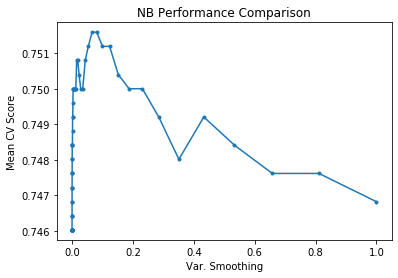

In [1282]:
plt.plot(results_NB['alpha'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [1283]:
yhat = mt_NB.predict(X_test_BOW)

In [1284]:
print (classification_report(Y_test, yhat))

              precision    recall  f1-score   support

           1       0.82      0.41      0.55        34
           2       0.30      0.19      0.23        16
           3       0.50      0.24      0.32        38
           4       0.37      0.24      0.29        82
           5       0.81      0.93      0.87       460

    accuracy                           0.75       630
   macro avg       0.56      0.40      0.45       630
weighted avg       0.72      0.75      0.73       630



In [ ]:
# try package 'CountVectorizer'

In [1285]:
from sklearn.feature_extraction.text import CountVectorizer

In [1286]:
vectorizer = CountVectorizer(min_df=5,ngram_range=(1, 2),stop_words=stop_words,max_features=200)
vectorizer_fit = vectorizer.fit(X_train)
print(vectorizer_fit.get_feature_names())

['34', 'able', 'add', 'alarm', 'alarm clock', 'alexa', 'also', 'amaze', 'amazon', 'another', 'answer', 'anything', 'app', 'around', 'ask', 'ask alexa', 'awesome', 'back', 'bedroom', 'best', 'big', 'bluetooth', 'bulb', 'buy', 'ca', 'call', 'clock', 'come', 'command', 'connect', 'control', 'cool', 'could', 'day', 'definitely', 'device', 'different', 'dot', 'easy', 'easy set', 'easy use', 'echo', 'echo dot', 'echo plus', 'echo show', 'echo spot', 'enjoy', 'enough', 'etc', 'even', 'every', 'everything', 'expect', 'family', 'far', 'feature', 'figure', 'find', 'fine', 'fire', 'first', 'full', 'fun', 'get', 'gift', 'give', 'go', 'good', 'google', 'great', 'great product', 'great sound', 'happy', 'hear', 'help', 'home', 'house', 'hub', 'information', 'issue', 'item', 'keep', 'kitchen', 'know', 'learn', 'light', 'like', 'list', 'listen', 'listen music', 'little', 'long', 'look', 'lot', 'love', 'love alexa', 'love echo', 'love love', 'make', 'many', 'money', 'movie', 'much', 'music', 'need', 'ne

In [1287]:
X_train_count = vectorizer_fit.transform(X_train)
X_test_count = vectorizer_fit.transform(X_test)

In [1288]:
mt_NB.fit(X_train_count, Y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] .......

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConve

[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.657933224657568 .........................................
[CV] .......................... alpha=0.657933224657568, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.2848035868435802 ........................................
[CV] ......................... alpha=0.2848035868435802, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.15199110829529336 .......................................
[CV] ........................ alpha=0.15199110829529336, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0657933224657568 ........................................
[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0657933224657568 ........................................
[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0657933224657568 ........................................
[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0657933224657568 ........................................
[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0657933224657568 ........................................
[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0657933224657568 ........................................
[CV] ......................... alpha=0.0657933224657568, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.03511191734215131, total=   0.0s
[CV] alpha=0.03511191734215131 .......................................
[CV] ........................ alpha=0.03511191734215131, total=   0.0s
[CV] alpha=0.02848035868435802 .......................................
[CV] ........................ alpha=0.02848035868435802, total=   0.0s
[CV] alpha=0.02848035868435802 .......................................
[CV] ........................ alpha=0.02848035868435802, total=   0.0s
[CV] alpha=0.02848035868435802 .......................................
[CV] ........................ alpha=0.02848035868435802, total=   0.0s
[CV] alpha=0.02848035868435802 .......................................
[CV] ........................ alpha=0.02848035868435802, total=   0.0s
[CV] alpha=0.02848035868435802 .......................................
[CV] ........................ alpha=0.02848035868435802, total=   0.0s
[CV] alpha=0.02848035868435802 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] ........................ alpha=0.01519911082952933, total=   0.0s
[CV] alpha=0.01519911082952933 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.008111308307896872, total=   0.0s
[CV] alpha=0.008111308307896872 ......................................
[CV] ....................... alpha=0.008111308307896872, total=   0.0s
[CV] alpha=0.008111308307896872 ......................................
[CV] ....................... alpha=0.008111308307896872, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] ....................... alpha=0.006579332246575682, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] ....................... alpha=0.006579332246575682, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] ....................... alpha=0.006579332246575682, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] ....................... alpha=0.006579332246575682, total=   0.0s
[CV] alpha=0.006579332246575682 ......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.003511191734215131 ......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.001873817422860383 ......................................
[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.001873817422860383 ......................................
[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.001873817422860383 ......................................
[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.001873817422860383 ......................................
[CV] ....................... alpha=0.001873817422860383, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] ...................... alpha=0.0008111308307896872, total=   0.0s
[CV] alpha=0.0008111308307896872 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0005336699231206307 .....................................
[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0005336699231206307 .....................................
[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0005336699231206307 .....................................
[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0005336699231206307 .....................................
[CV] ...................... alpha=0.0005336699231206307, total=   0.0s
[CV] alpha=0.0004328761281083057 .....................................
[CV] ...................... alpha=0.0004328761281083057, total=   0.0s
[CV] alpha=0.0004328761281083057 .....................................
[CV] ...................... alpha=0.0004328761281083057, total=   0.0s
[CV] alpha=0.0004328761281083057 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002310129700083158 .....................................
[CV] ...................... alpha=0.0002310129700083158, total=   0.0s
[CV] alpha=0.0002310129700083158 .....................................
[CV] ...................... alpha=0.0002310129700083158, total=   0.0s
[CV] alpha=0.0002310129700083158 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] ...................... alpha=0.0001232846739442066, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] ...................... alpha=0.0001232846739442066, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] ...................... alpha=0.0001232846739442066, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] ...................... alpha=0.0001232846739442066, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] ...................... alpha=0.0001232846739442066, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] ...................... alpha=8.111308307896872e-05, total=   0.0s
[CV] alpha=8.111308307896872e-05 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=4.328761281083062e-05 .....................................
[CV] ...................... alpha=4.328761281083062e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] ...................... alpha=3.511191734215127e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] alpha=2.310129700083158e-05 .....................................
[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] alpha=2.310129700083158e-05 .....................................
[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] alpha=2.310129700083158e-05 .....................................
[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] alpha=2.310129700083158e-05 .....................................
[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] alpha=2.310129700083158e-05 .....................................
[CV] ...................... alpha=2.310129700083158e-05, total=   0.0s
[CV] alpha=1.873817422860383e-05 .....................................
[CV] ...................... alpha=1.873817422860383e-05, total=   0.0s
[CV] alpha=1.873817422860383e-05 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1.2328467394420658e-05 ....................................
[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1.2328467394420658e-05 ....................................
[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1.2328467394420658e-05 ....................................
[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1.2328467394420658e-05 ....................................
[CV] ..................... alpha=1.2328467394420658e-05, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=5.336699231206313e-06 .....................................
[CV] ...................... alpha=5.336699231206313e-06, total=   0.0s
[CV] alpha=5.336699231206313e-06 .....................................
[CV] ...................... alpha=5.336699231206313e-06, total=   0.0s
[CV] alpha=5.336699231206313e-06 .....................................
[CV] ...................... alpha=5.336699231206313e-06, total=   0.0s
[CV] alpha=5.336699231206313e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] ...................... alpha=2.848035868435799e-06, total=   0.0s
[CV] alpha=2.848035868435799e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.873817422860383e-06 .....................................
[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.873817422860383e-06 .....................................
[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.873817422860383e-06 .....................................
[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.873817422860383e-06 .....................................
[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=4.3287612810830526e-07, total=   0.0s
[CV] alpha=4.3287612810830526e-07 ....................................
[CV] ..................... alpha=4.3287612810830526e-07, total=   0.0s
[CV] alpha=4.3287612810830526e-07 ....................................
[CV] ..................... alpha=4.3287612810830526e-07, total=   0.0s
[CV] alpha=4.3287612810830526e-07 ....................................
[CV] ..................... alpha=4.3287612810830526e-07, total=   0.0s
[CV] alpha=4.3287612810830526e-07 ....................................
[CV] ..................... alpha=4.3287612810830526e-07, total=   0.0s
[CV] alpha=4.3287612810830526e-07 ....................................
[CV] ..................... alpha=4.3287612810830526e-07, total=   0.0s
[CV] alpha=4.3287612810830526e-07 ....................................
[CV] ..................... alpha=4.3287612810830526e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=2.310129700083158e-07 .....................................
[CV] ...................... alpha=2.310129700083158e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.873817422860383e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] ...................... alpha=1.232846739442066e-07, total=   0.0s
[CV] alpha=1.232846739442066e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=4.3287612810830526e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.310129700083158e-08, total=   0.0s
[CV] alpha=2.310129700083158e-08 .....................................
[CV] ...................... alpha=2.310129700083158e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1.232846739442066e-08 .....................................
[CV] ...................... alpha=1.232846739442066e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=6.579332246575682e-09, total=   0.0s
[CV] alpha=6.579332246575682e-09 .....................................
[CV] ...................... alpha=6.579332246575682e-09, total=   0.0s
[CV] alpha=6.579332246575682e-09 .....................................
[CV] ...................... alpha=6.579332246575682e-09, total=   0.0s
[CV] alpha=6.579332246575682e-09 .....................................
[CV] ...................... alpha=6.579332246575682e-09, total=   0.0s
[CV] alpha=6.579332246575682e-09 .....................................
[CV] ...................... alpha=6.579332246575682e-09, total=   0.0s
[CV] alpha=6.579332246575682e-09 .....................................
[CV] ...................... alpha=6.579332246575682e-09, total=   0.0s
[CV] alpha=6.579332246575682e-09 .....................................
[CV] ...................... alpha=6.579332246575682e-09, total=   0.0s
[CV] alpha=6.579332246575682e-09 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] ..................... alpha=3.5111917342151273e-09, total=   0.0s
[CV] alpha=3.5111917342151273e-09 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=1.873817422860387e-09 .....................................
[CV] ...................... alpha=1.873817422860387e-09, total=   0.0s
[CV] alpha=1.873817422860387e-09 .....................................
[CV] ...................... alpha=1.873817422860387e-09, total=   0.0s
[CV] alpha=1.873817422860387e-09 .....................................
[CV] ...................... alpha=1.873817422860387e-09, total=   0.0s
[CV] alpha=1.873817422860387e-09 .....................................
[CV] ...................... alpha=1.873817422860387e-09, total=   0.0s
[CV] alpha=1.873817422860387e-09 .....................................
[CV] ...................... alpha=1.873817422860387e-09, total=   0.0s
[CV] alpha=1.873817422860387e-09 .....................................
[CV] ...................... alpha=1.873817422860387e-09, total=   0.0s
[CV] alpha=1.873817422860387e-09 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8....
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [1289]:
results_NB = pd.DataFrame(mt_NB.cv_results_['params'])
results_NB['test_score'] = mt_NB.cv_results_['mean_test_score']

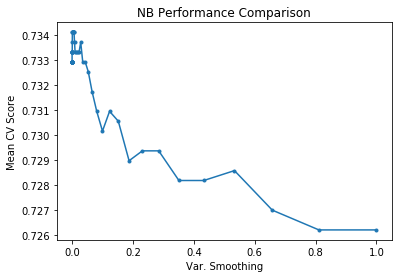

In [1290]:
plt.plot(results_NB['alpha'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [1291]:
yhat = mt_NB.predict(X_test_count)

In [1292]:
print (classification_report(Y_test, yhat))

              precision    recall  f1-score   support

           1       0.75      0.44      0.56        34
           2       0.20      0.12      0.15        16
           3       0.35      0.18      0.24        38
           4       0.32      0.20      0.24        82
           5       0.81      0.93      0.87       460

    accuracy                           0.75       630
   macro avg       0.49      0.38      0.41       630
weighted avg       0.70      0.75      0.71       630



In [1293]:
from sklearn.metrics import confusion_matrix

In [1294]:
confusion_matrix(Y_test,yhat)

array([[ 15,   1,   2,   4,  12],
       [  2,   2,   1,   3,   8],
       [  2,   4,   7,   4,  21],
       [  0,   0,   7,  16,  59],
       [  1,   3,   3,  23, 430]])

In [1295]:
#TF-IDF - MultinomialNB

In [1296]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [1297]:
tfidf = TfidfVectorizer(min_df=5,ngram_range=(1, 2),stop_words=stop_words,max_features=200)
tf_fit = tfidf.fit(X_train)
print(tf_fit.get_feature_names())

['34', 'able', 'add', 'alarm', 'alarm clock', 'alexa', 'also', 'amaze', 'amazon', 'another', 'answer', 'anything', 'app', 'around', 'ask', 'ask alexa', 'awesome', 'back', 'bedroom', 'best', 'big', 'bluetooth', 'bulb', 'buy', 'ca', 'call', 'clock', 'come', 'command', 'connect', 'control', 'cool', 'could', 'day', 'definitely', 'device', 'different', 'dot', 'easy', 'easy set', 'easy use', 'echo', 'echo dot', 'echo plus', 'echo show', 'echo spot', 'enjoy', 'enough', 'etc', 'even', 'every', 'everything', 'expect', 'family', 'far', 'feature', 'figure', 'find', 'fine', 'fire', 'first', 'full', 'fun', 'get', 'gift', 'give', 'go', 'good', 'google', 'great', 'great product', 'great sound', 'happy', 'hear', 'help', 'home', 'house', 'hub', 'information', 'issue', 'item', 'keep', 'kitchen', 'know', 'learn', 'light', 'like', 'list', 'listen', 'listen music', 'little', 'long', 'look', 'lot', 'love', 'love alexa', 'love echo', 'love love', 'make', 'many', 'money', 'movie', 'much', 'music', 'need', 'ne

In [975]:
X_train_tfidf = tf_fit.transform(X_train)
X_test_tfidf = tf_fit.transform(X_test)

In [976]:
X_train_tfidf.shape

(2520, 200)

In [977]:
X_test_tfidf.shape

(630, 200)

In [978]:
print(X_train_tfidf[5])

  (0, 197)	0.12570410738903984
  (0, 196)	0.4686511940783173
  (0, 180)	0.14180545522987487
  (0, 140)	0.1517002481333184
  (0, 132)	0.1238806722990604
  (0, 128)	0.15117780702608896
  (0, 125)	0.15066372533614814
  (0, 88)	0.18861621473100812
  (0, 82)	0.16219642302923065
  (0, 70)	0.08223634076888696
  (0, 68)	0.16525868384238962
  (0, 61)	0.11605323604330434
  (0, 37)	0.1686438561190087
  (0, 35)	0.6718846634153751
  (0, 33)	0.12864932100474583
  (0, 32)	0.143392415819082
  (0, 7)	0.11934206815728364
  (0, 0)	0.14104043289353718


In [979]:
np.random.seed(999)

nb_classifier = MultinomialNB()

params_NB = {'alpha': np.logspace(0,-9, num=100)}

mt_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=10,
                     verbose=2, 
                     refit = True,
                     scoring='accuracy')

mt_NB.fit(X_train_tfidf, Y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] ........................................ alpha=1.0, total=   0.0s
[CV] alpha=1.0 .......................................................
[CV] .......

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConve

[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.533669923120631 .........................................
[CV] .......................... alpha=0.533669923120631, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] ........................ alpha=0.43287612810830584, total=   0.0s
[CV] alpha=0.43287612810830584 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] ........................ alpha=0.23101297000831597, total=   0.0s
[CV] alpha=0.23101297000831597 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.12328467394420659 .......................................
[CV] ........................ alpha=0.12328467394420659, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.0533669923120631 ........................................
[CV] ......................... alpha=0.0533669923120631, total=   0.0s
[CV] alpha=0.04328761281083057 .......................................
[CV] ........................ alpha=0.04328761281083057, total=   0.0s
[CV] alpha=0.04328761281083057 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] ........................ alpha=0.02310129700083159, total=   0.0s
[CV] alpha=0.02310129700083159 .......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.012328467394420659, total=   0.0s
[CV] alpha=0.012328467394420659 ......................................
[CV] ....................... alpha=0.012328467394420659, total=   0.0s
[CV] alpha=0.012328467394420659 ......................................
[CV] ....................... alpha=0.012328467394420659, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] ....................... alpha=0.005336699231206307, total=   0.0s
[CV] alpha=0.005336699231206307 ......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ....................... alpha=0.003511191734215131, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] ....................... alpha=0.002848035868435802, total=   0.0s
[CV] alpha=0.002848035868435802 ......................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0015199110829529332 .....................................
[CV] ...................... alpha=0.0015199110829529332, total=   0.0s
[CV] alpha=0.0012328467394420659 .....................................
[CV] ...................... alpha=0.0012328467394420659, total=   0.0s
[CV] alpha=0.0012328467394420659 .....................................
[CV] ...................... alpha=0.0012328467394420659, total=   0.0s
[CV] alpha=0.0012328467394420659 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] ...................... alpha=0.0006579332246575676, total=   0.0s
[CV] alpha=0.0006579332246575676 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0003511191734215131, total=   0.0s
[CV] alpha=0.0003511191734215131 .....................................
[CV] ...................... alpha=0.0003511191734215131, total=   0.0s
[CV] alpha=0.0003511191734215131 .....................................
[CV] ...................... alpha=0.0003511191734215131, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] ...................... alpha=0.0002848035868435802, total=   0.0s
[CV] alpha=0.0002848035868435802 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001519911082952933 .....................................
[CV] ...................... alpha=0.0001519911082952933, total=   0.0s
[CV] alpha=0.0001232846739442066 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] ...................... alpha=6.579332246575683e-05, total=   0.0s
[CV] alpha=6.579332246575683e-05 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=3.511191734215127e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] ...................... alpha=3.511191734215127e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] ...................... alpha=3.511191734215127e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] ...................... alpha=3.511191734215127e-05, total=   0.0s
[CV] alpha=3.511191734215127e-05 .....................................
[CV] ...................... alpha=3.511191734215127e-05, total=   0.0s
[CV] alpha=2.848035868435799e-05 .....................................
[CV] ...................... alpha=2.848035868435799e-05, total=   0.0s
[CV] alpha=2.848035868435799e-05 .....................................
[CV] ...................... alpha=2.848035868435799e-05, total=   0.0s
[CV] alpha=2.848035868435799e-05 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] ..................... alpha=1.5199110829529332e-05, total=   0.0s
[CV] alpha=1.5199110829529332e-05 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=8.111308307896873e-06, total=   0.0s
[CV] alpha=8.111308307896873e-06 .....................................
[CV] ...................... alpha=8.111308307896873e-06, total=   0.0s
[CV] alpha=8.111308307896873e-06 .....................................
[CV] ...................... alpha=8.111308307896873e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] ...................... alpha=6.579332246575683e-06, total=   0.0s
[CV] alpha=6.579332246575683e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] ..................... alpha=3.5111917342151275e-06, total=   0.0s
[CV] alpha=3.5111917342151275e-06 ....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.873817422860383e-06 .....................................
[CV] ...................... alpha=1.873817422860383e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] ...................... alpha=1.519911082952933e-06, total=   0.0s
[CV] alpha=1.519911082952933e-06 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=8.111308307896872e-07 .....................................
[CV] ...................... alpha=8.111308307896872e-07, total=   0.0s
[CV] alpha=6.579332246575682e-07 .....................................
[CV] ...................... alpha=6.579332246575682e-07, total=   0.0s
[CV] alpha=6.579332246575682e-07 .....................................
[CV] ...................... alpha=6.579332246575682e-07, total=   0.0s
[CV] alpha=6.579332246575682e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi


[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] ..................... alpha=3.5111917342151277e-07, total=   0.0s
[CV] alpha=3.5111917342151277e-07 ....................................
[CV] 

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.873817422860383e-07, total=   0.0s
[CV] alpha=1.519911082952933e-07 .....................................
[CV] ...................... alpha=1.519911082952933e-07, total=   0.0s
[CV] alpha=1.519911082952933e-07 .....................................
[CV] ...................... alpha=1.519911082952933e-07, total=   0.0s
[CV] alpha=1.519911082952933e-07 .....................................
[CV] ...................... alpha=1.519911082952933e-07, total=   0.0s
[CV] alpha=1.519911082952933e-07 .....................................
[CV] ...................... alpha=1.519911082952933e-07, total=   0.0s
[CV] alpha=1.519911082952933e-07 .....................................
[CV] ...................... alpha=1.519911082952933e-07, total=   0.0s
[CV] alpha=1.519911082952933e-07 .....................................
[CV] ...................... alpha=1.519911082952933e-07, total=   0.0s
[CV] alpha=1.519911082952933e-07 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=8.111308307896873e-08 .....................................
[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=8.111308307896873e-08 .....................................
[CV] ...................... alpha=8.111308307896873e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] ...................... alpha=6.579332246575682e-08, total=   0.0s
[CV] alpha=6.579332246575682e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=3.5111917342151277e-08 ....................................
[CV] ..................... alpha=3.5111917342151277e-08, total=   0.0s
[CV] alpha=2.848035868435799e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.873817422860383e-08 .....................................
[CV] ...................... alpha=1.873817422860383e-08, total=   0.0s
[CV] alpha=1.519911082952933e-08 .....................................
[CV] ...................... alpha=1.519911082952933e-08, total=   0.0s
[CV] alpha=1.519911082952933e-08 .....................................
[CV] ...................... alpha=1.519911082952933e-08, total=   0.0s
[CV] alpha=1.519911082952933e-08 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=1e-08 .....................................................
[CV] ...................................... alpha=1e-08, total=   0.0s
[CV] alpha=8.111308307896856e-09 .....................................
[CV] ...................... alpha=8.111308307896856e-09, total=   0.0s
[CV] alpha=8.111308307896856e-09 .....................................
[CV] ...................... alpha=8.111308307896856e-09, total=   0.0s
[CV] alpha=8.111308307896856e-09 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=5.336699231206302e-09 .....................................
[CV] ...................... alpha=5.336699231206302e-09, total=   0.0s
[CV] alpha=4.328761281083061e-09 .....................................
[CV] ...................... alpha=4.328761281083061e-09, total=   0.0s
[CV] alpha=4.328761281083061e-09 .....................................
[CV] ...................... alpha=4.328761281083061e-09, total=   0.0s
[CV] alpha=4.328761281083061e-09 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ...................... alpha=2.848035868435805e-09, total=   0.0s
[CV] alpha=2.848035868435805e-09 .....................................
[CV] ...................... alpha=2.848035868435805e-09, total=   0.0s
[CV] alpha=2.848035868435805e-09 .....................................
[CV] ...................... alpha=2.848035868435805e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] ...................... alpha=2.310129700083158e-09, total=   0.0s
[CV] alpha=2.310129700083158e-09 .....................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

[CV] ..................... alpha=1.2328467394420635e-09, total=   0.0s
[CV] alpha=1.2328467394420635e-09 ....................................
[CV] ..................... alpha=1.2328467394420635e-09, total=   0.0s
[CV] alpha=1.2328467394420635e-09 ....................................
[CV] ..................... alpha=1.2328467394420635e-09, total=   0.0s
[CV] alpha=1.2328467394420635e-09 ....................................
[CV] ..................... alpha=1.2328467394420635e-09, total=   0.0s
[CV] alpha=1.2328467394420635e-09 ....................................
[CV] ..................... alpha=1.2328467394420635e-09, total=   0.0s
[CV] alpha=1.2328467394420635e-09 ....................................
[CV] ..................... alpha=1.2328467394420635e-09, total=   0.0s
[CV] alpha=1.2328467394420635e-09 ....................................
[CV] ..................... alpha=1.2328467394420635e-09, total=   0.0s
[CV] alpha=1e-09 .....................................................
[CV] .

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/olivi

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8....
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [980]:
mt_NB.best_params_

{'alpha': 0.3511191734215131}

In [981]:
results_NB = pd.DataFrame(mt_NB.cv_results_['params'])
results_NB['test_score'] = mt_NB.cv_results_['mean_test_score']

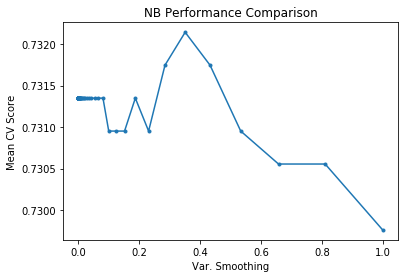

In [982]:
plt.plot(results_NB['alpha'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [983]:
yhat = mt_NB.predict(X_test_tfidf)

In [984]:
print (classification_report(Y_test, yhat))

              precision    recall  f1-score   support

           1       1.00      0.03      0.06        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        38
           4       0.33      0.02      0.05        82
           5       0.74      1.00      0.85       460

    accuracy                           0.73       630
   macro avg       0.41      0.21      0.19       630
weighted avg       0.64      0.73      0.63       630



/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [985]:
confusion_matrix(Y_test,yhat)

array([[  1,   0,   0,   0,  33],
       [  0,   0,   0,   0,  16],
       [  0,   0,   0,   3,  35],
       [  0,   0,   0,   2,  80],
       [  0,   0,   0,   1, 459]])

In [ ]:
#TF-IDF - NN 

In [1034]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [1035]:
def build_ann(optimizer):
# Initializing the ANN
    classifier = Sequential()
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
    classifier.add(Dense(20, activation = 'relu', init = 'he_normal', input_shape = (X_train_tfidf.shape[1], )))
    classifier.add(Dropout(rate=0.5)) 
# Adding the second hidden layer
# Notice that we do not need to specify input dim. 
    classifier.add(Dense(10, init = 'he_normal', activation = 'relu')) 
    classifier.add(Dropout(rate=0.5)) 
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
    classifier.add(Dense(5, activation = 'softmax')) 
    classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
    return classifier

In [1100]:
# Initializing the ANN
classifier = Sequential()
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
classifier.add(Dense(20, activation = 'relu', init = 'he_normal', input_shape = (X_train_tfidf.shape[1], )))
classifier.add(Dropout(rate=0.5)) 
# Adding the second hidden layer
# Notice that we do not need to specify input dim. 
classifier.add(Dense(10, init = 'he_normal', activation = 'relu')) 
classifier.add(Dropout(rate=0.5)) 
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
classifier.add(Dense(5, activation = 'softmax')) 
classifier.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", input_shape=(200,), kernel_initializer="he_normal")`

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="he_normal")`



In [1030]:
classifier.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                4020      
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_14 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 55        
Total params: 4,285
Trainable params: 4,285
Non-trainable params: 0
_________________________________________________________________


In [1031]:
classifier=KerasClassifier(build_fn=build_ann)
parameters={'batch_size':[32, 64, 128, 256],
           'epochs':[10,25,50,100],
           'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,
                        param_grid=parameters,
                        scoring='accuracy',
                        refit = True,
                        verbose=2,
                        cv=10)

In [1032]:
grid_search=grid_search.fit(X_train_tfidf, Y_train_oh, validation_split = 0.1)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] batch_size=32, epochs=10, optimizer=adam ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", input_shape=(200,), kernel_initializer="he_normal")`

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="he_normal")`



Train on 2041 samples, validate on 227 samples
Epoch 1/10


KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [1101]:
history = classifier.fit(X_train_tfidf, Y_train_oh, batch_size=512, epochs=500, validation_split=0.1, verbose=2,shuffle= True)

Train on 2268 samples, validate on 252 samples
Epoch 1/500
 - 2s - loss: 1.6433 - accuracy: 0.1274 - val_loss: 1.6274 - val_accuracy: 0.0952
Epoch 2/500
 - 0s - loss: 1.6315 - accuracy: 0.1861 - val_loss: 1.6155 - val_accuracy: 0.1667
Epoch 3/500
 - 0s - loss: 1.6179 - accuracy: 0.2438 - val_loss: 1.6059 - val_accuracy: 0.2579
Epoch 4/500
 - 0s - loss: 1.6093 - accuracy: 0.2835 - val_loss: 1.5982 - val_accuracy: 0.3651
Epoch 5/500
 - 0s - loss: 1.6002 - accuracy: 0.3228 - val_loss: 1.5918 - val_accuracy: 0.4643
Epoch 6/500
 - 0s - loss: 1.5913 - accuracy: 0.3968 - val_loss: 1.5857 - val_accuracy: 0.6032
Epoch 7/500
 - 0s - loss: 1.5851 - accuracy: 0.4343 - val_loss: 1.5797 - val_accuracy: 0.6627
Epoch 8/500
 - 0s - loss: 1.5783 - accuracy: 0.4718 - val_loss: 1.5732 - val_accuracy: 0.7183
Epoch 9/500
 - 0s - loss: 1.5722 - accuracy: 0.4934 - val_loss: 1.5663 - val_accuracy: 0.7421
Epoch 10/500
 - 0s - loss: 1.5652 - accuracy: 0.5317 - val_loss: 1.5588 - val_accuracy: 0.7421
Epoch 11/500

Epoch 87/500
 - 0s - loss: 0.8719 - accuracy: 0.7218 - val_loss: 0.7536 - val_accuracy: 0.7500
Epoch 88/500
 - 0s - loss: 0.8624 - accuracy: 0.7218 - val_loss: 0.7524 - val_accuracy: 0.7500
Epoch 89/500
 - 0s - loss: 0.8650 - accuracy: 0.7218 - val_loss: 0.7512 - val_accuracy: 0.7500
Epoch 90/500
 - 0s - loss: 0.8607 - accuracy: 0.7222 - val_loss: 0.7497 - val_accuracy: 0.7500
Epoch 91/500
 - 0s - loss: 0.8535 - accuracy: 0.7218 - val_loss: 0.7481 - val_accuracy: 0.7500
Epoch 92/500
 - 0s - loss: 0.8606 - accuracy: 0.7213 - val_loss: 0.7464 - val_accuracy: 0.7500
Epoch 93/500
 - 0s - loss: 0.8630 - accuracy: 0.7218 - val_loss: 0.7454 - val_accuracy: 0.7500
Epoch 94/500
 - 0s - loss: 0.8639 - accuracy: 0.7218 - val_loss: 0.7442 - val_accuracy: 0.7500
Epoch 95/500
 - 0s - loss: 0.8378 - accuracy: 0.7218 - val_loss: 0.7433 - val_accuracy: 0.7500
Epoch 96/500
 - 0s - loss: 0.8374 - accuracy: 0.7218 - val_loss: 0.7422 - val_accuracy: 0.7500
Epoch 97/500
 - 0s - loss: 0.8492 - accuracy: 0.72

Epoch 173/500
 - 0s - loss: 0.7532 - accuracy: 0.7275 - val_loss: 0.7250 - val_accuracy: 0.7500
Epoch 174/500
 - 0s - loss: 0.7521 - accuracy: 0.7235 - val_loss: 0.7245 - val_accuracy: 0.7500
Epoch 175/500
 - 0s - loss: 0.7624 - accuracy: 0.7253 - val_loss: 0.7243 - val_accuracy: 0.7500
Epoch 176/500
 - 0s - loss: 0.7628 - accuracy: 0.7249 - val_loss: 0.7239 - val_accuracy: 0.7500
Epoch 177/500
 - 0s - loss: 0.7392 - accuracy: 0.7257 - val_loss: 0.7235 - val_accuracy: 0.7500
Epoch 178/500
 - 0s - loss: 0.7515 - accuracy: 0.7284 - val_loss: 0.7232 - val_accuracy: 0.7500
Epoch 179/500
 - 0s - loss: 0.7470 - accuracy: 0.7280 - val_loss: 0.7228 - val_accuracy: 0.7500
Epoch 180/500
 - 0s - loss: 0.7509 - accuracy: 0.7288 - val_loss: 0.7226 - val_accuracy: 0.7500
Epoch 181/500
 - 0s - loss: 0.7419 - accuracy: 0.7280 - val_loss: 0.7224 - val_accuracy: 0.7500
Epoch 182/500
 - 0s - loss: 0.7541 - accuracy: 0.7275 - val_loss: 0.7223 - val_accuracy: 0.7500
Epoch 183/500
 - 0s - loss: 0.7487 - acc

Epoch 259/500
 - 0s - loss: 0.6933 - accuracy: 0.7474 - val_loss: 0.7246 - val_accuracy: 0.7540
Epoch 260/500
 - 0s - loss: 0.6933 - accuracy: 0.7407 - val_loss: 0.7250 - val_accuracy: 0.7540
Epoch 261/500
 - 0s - loss: 0.6897 - accuracy: 0.7465 - val_loss: 0.7264 - val_accuracy: 0.7540
Epoch 262/500
 - 0s - loss: 0.6824 - accuracy: 0.7390 - val_loss: 0.7272 - val_accuracy: 0.7540
Epoch 263/500
 - 0s - loss: 0.6921 - accuracy: 0.7421 - val_loss: 0.7263 - val_accuracy: 0.7540
Epoch 264/500
 - 0s - loss: 0.6826 - accuracy: 0.7447 - val_loss: 0.7259 - val_accuracy: 0.7540
Epoch 265/500
 - 0s - loss: 0.6972 - accuracy: 0.7447 - val_loss: 0.7252 - val_accuracy: 0.7540
Epoch 266/500
 - 0s - loss: 0.6839 - accuracy: 0.7482 - val_loss: 0.7257 - val_accuracy: 0.7540
Epoch 267/500
 - 0s - loss: 0.6865 - accuracy: 0.7460 - val_loss: 0.7268 - val_accuracy: 0.7540
Epoch 268/500
 - 0s - loss: 0.6958 - accuracy: 0.7385 - val_loss: 0.7268 - val_accuracy: 0.7540
Epoch 269/500
 - 0s - loss: 0.6900 - acc

Epoch 345/500
 - 0s - loss: 0.6537 - accuracy: 0.7522 - val_loss: 0.7449 - val_accuracy: 0.7619
Epoch 346/500
 - 0s - loss: 0.6457 - accuracy: 0.7584 - val_loss: 0.7446 - val_accuracy: 0.7619
Epoch 347/500
 - 0s - loss: 0.6350 - accuracy: 0.7628 - val_loss: 0.7447 - val_accuracy: 0.7619
Epoch 348/500
 - 0s - loss: 0.6431 - accuracy: 0.7584 - val_loss: 0.7448 - val_accuracy: 0.7619
Epoch 349/500
 - 0s - loss: 0.6243 - accuracy: 0.7601 - val_loss: 0.7453 - val_accuracy: 0.7619
Epoch 350/500
 - 0s - loss: 0.6467 - accuracy: 0.7518 - val_loss: 0.7444 - val_accuracy: 0.7619
Epoch 351/500
 - 0s - loss: 0.6429 - accuracy: 0.7526 - val_loss: 0.7437 - val_accuracy: 0.7619
Epoch 352/500
 - 0s - loss: 0.6443 - accuracy: 0.7562 - val_loss: 0.7439 - val_accuracy: 0.7579
Epoch 353/500
 - 0s - loss: 0.6342 - accuracy: 0.7593 - val_loss: 0.7449 - val_accuracy: 0.7579
Epoch 354/500
 - 0s - loss: 0.6276 - accuracy: 0.7575 - val_loss: 0.7454 - val_accuracy: 0.7579
Epoch 355/500
 - 0s - loss: 0.6204 - acc

Epoch 431/500
 - 0s - loss: 0.6031 - accuracy: 0.7654 - val_loss: 0.7690 - val_accuracy: 0.7540
Epoch 432/500
 - 0s - loss: 0.6185 - accuracy: 0.7672 - val_loss: 0.7699 - val_accuracy: 0.7540
Epoch 433/500
 - 0s - loss: 0.6078 - accuracy: 0.7668 - val_loss: 0.7708 - val_accuracy: 0.7540
Epoch 434/500
 - 0s - loss: 0.6191 - accuracy: 0.7623 - val_loss: 0.7719 - val_accuracy: 0.7540
Epoch 435/500
 - 0s - loss: 0.6088 - accuracy: 0.7690 - val_loss: 0.7734 - val_accuracy: 0.7540
Epoch 436/500
 - 0s - loss: 0.6070 - accuracy: 0.7632 - val_loss: 0.7739 - val_accuracy: 0.7540
Epoch 437/500
 - 0s - loss: 0.6207 - accuracy: 0.7606 - val_loss: 0.7732 - val_accuracy: 0.7540
Epoch 438/500
 - 0s - loss: 0.6074 - accuracy: 0.7641 - val_loss: 0.7724 - val_accuracy: 0.7540
Epoch 439/500
 - 0s - loss: 0.6069 - accuracy: 0.7632 - val_loss: 0.7722 - val_accuracy: 0.7540
Epoch 440/500
 - 0s - loss: 0.6093 - accuracy: 0.7663 - val_loss: 0.7724 - val_accuracy: 0.7540
Epoch 441/500
 - 0s - loss: 0.6078 - acc

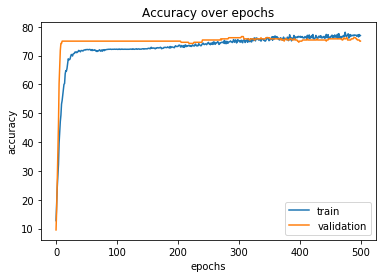

In [1102]:
plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

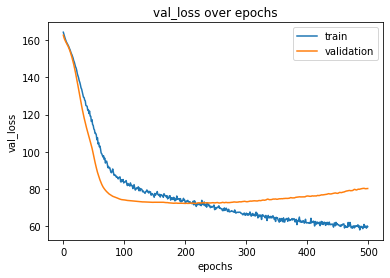

In [1103]:
plt.plot(np.array(history.history['loss']) * 100)
plt.plot(np.array(history.history['val_loss']) * 100)
plt.ylabel('val_loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('val_loss over epochs')
plt.show()

In [1069]:
loss, acc = classifier.evaluate(X_test_tfidf, Y_test_oh)
print("Test accuracy = ", acc)

630/630 [==============================] - 0s 88us/step
Test accuracy =  0.9076189994812012


In [1070]:
loss

0.2774647067463587

In [1071]:
y_pred = classifier.predict(X_test_tfidf)

In [1072]:
metrics.confusion_matrix(Y_test_oh.argmax(axis=1), y_pred.argmax(axis=1))

array([[  0,   0,   0,  16,  18],
       [  0,   0,   0,   5,  11],
       [  0,   0,   0,  17,  21],
       [  0,   0,   0,  25,  57],
       [  0,   0,   0,  32, 428]])

In [1073]:
print (classification_report(Y_test_oh.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        38
           3       0.26      0.30      0.28        82
           4       0.80      0.93      0.86       460

    accuracy                           0.72       630
   macro avg       0.21      0.25      0.23       630
weighted avg       0.62      0.72      0.66       630



In [ ]:
#One-hot coding - NN 

In [ ]:
from sklearn.preprocessing import Binarizer

freq   = CountVectorizer()
corpus = freq.fit_transform(corpus)

onehot = Binarizer()
corpus = onehot.fit_transform(corpus.toarray())

In [ ]:
# GloVe embedding - LSTM

In [1076]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text


In [1077]:
#Apply function on review column
reviews['verified_reviews']=reviews['verified_reviews'].apply(denoise_text)

In [1078]:
reviews['verified_reviews']

0                                              Love Echo!
1                                               Loved it!
2       Sometimes playing game, answer question correc...
3       lot fun thing. 4 yr old learns dinosaurs, cont...
4                                                   Music
                              ...                        
3145              Perfect kids, adults everyone between!!
3146    Listening music, searching locations, checking...
3147    love things, running entire home, TV, lights, ...
3148    complaint sound quality great. mostly use comm...
3149                                                 Good
Name: verified_reviews, Length: 3150, dtype: object

In [1079]:
x_train,x_test,y_train,y_test = train_test_split(reviews['verified_reviews'], pd.DataFrame(reviews['rating']),random_state = 0)

In [1080]:
max_features = 1000
maxlen = 100

In [1081]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

word2idx = tokenizer.word_index # of unique tokens

In [1082]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [1083]:
EMBEDDING_FILE = '/Users/olivia/Desktop/Alexa Reviews/glove.6B.50d.txt'

In [1084]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [1086]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1] #50

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [1119]:
batch_size = 256
epochs = 10
class_weight = class_weight.compute_sample_weight('balanced',Y_train)

In [1088]:
embedding_matrix

array([[-0.29873529,  0.90492621, -0.04982458, ...,  0.30373246,
         0.35923426,  0.22564106],
       [-0.13886   ,  1.1401    , -0.85211998, ..., -1.37109995,
        -0.28606001,  0.28979999],
       [ 0.44187   ,  0.72175002,  0.012795  , ...,  0.56212997,
         0.010063  , -0.018614  ],
       ...,
       [ 0.60570002, -0.094638  ,  0.84211999, ...,  0.3206    ,
        -0.30612001,  0.47968   ],
       [-0.15555   ,  0.27465001,  1.11109996, ..., -0.116     ,
         0.20013   ,  0.30181   ],
       [-0.16201   , -0.16648   , -0.58841002, ...,  0.093984  ,
         0.11336   ,  0.29102999]])

In [1089]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [1104]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [1105]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          91648     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 165       
Total params: 193,301
Trainable params: 143,301
Non-trainable params: 50,000
_________________________________________________________________


In [1115]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

In [1120]:
history = model.fit(X_train, Y_train_oh, batch_size = batch_size , class_weight=class_weight, validation_split=0.1 , epochs = epochs , callbacks = [learning_rate_reduction])

Train on 2268 samples, validate on 252 samples
Epoch 1/10
2268/2268 [==============================] - 20s 9ms/step - loss: 0.7867 - accuracy: 0.7231 - val_loss: 0.8040 - val_accuracy: 0.7421
Epoch 2/10
2268/2268 [==============================] - 19s 9ms/step - loss: 0.7798 - accuracy: 0.7280 - val_loss: 0.8034 - val_accuracy: 0.7262
Epoch 3/10
2268/2268 [==============================] - 20s 9ms/step - loss: 0.7778 - accuracy: 0.7262 - val_loss: 0.7979 - val_accuracy: 0.7262

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 4/10
2268/2268 [==============================] - 19s 8ms/step - loss: 0.7721 - accuracy: 0.7262 - val_loss: 0.7924 - val_accuracy: 0.7421
Epoch 5/10
2268/2268 [==============================] - 19s 9ms/step - loss: 0.7660 - accuracy: 0.7284 - val_loss: 0.7901 - val_accuracy: 0.7262

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 6/10
2268/2268 [==============================] - 20s 9ms/st

In [1109]:
loss, acc = model.evaluate(X_test, Y_test_oh)
print("Test accuracy = ", acc)

630/630 [==============================] - 4s 6ms/step
Test accuracy =  0.7269841432571411


In [1110]:
Y_pred = model.predict(X_test)

In [1111]:
Y_pred

array([[0.04775095, 0.02736688, 0.05068106, 0.21297765, 0.6612235 ],
       [0.03698661, 0.0127727 , 0.02477589, 0.1522138 , 0.77325106],
       [0.03896391, 0.02300162, 0.04713033, 0.18881842, 0.7020857 ],
       ...,
       [0.0333542 , 0.02000165, 0.04123697, 0.17503673, 0.7303704 ],
       [0.03191055, 0.00869105, 0.01720276, 0.13658337, 0.8056122 ],
       [0.17008953, 0.17490211, 0.12501903, 0.3023223 , 0.2276671 ]],
      dtype=float32)

In [1112]:
metrics.confusion_matrix(Y_test_oh.argmax(axis=1), Y_pred.argmax(axis=1))

array([[  0,   0,   0,   4,  30],
       [  0,   0,   0,   0,  16],
       [  0,   0,   0,   4,  34],
       [  0,   0,   0,   4,  78],
       [  0,   0,   0,   6, 454]])

In [1113]:
print (classification_report(Y_test_oh.argmax(axis=1), Y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        38
           3       0.22      0.05      0.08        82
           4       0.74      0.99      0.85       460

    accuracy                           0.73       630
   macro avg       0.19      0.21      0.19       630
weighted avg       0.57      0.73      0.63       630



/Users/olivia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [ ]:
# GloVe embedding - GRU

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

In [ ]:
#Word2vec embedding - LSTM

In [1124]:
pip install gensim

     |████████████████████████████████| 24.2MB 19.7MB/s eta 0:00:01
     |████████████████████████████████| 112kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 102kB 1.2MB/s ta 0:00:01
     |████████████████████████████████| 6.6MB 2.1MB/s eta 0:00:01     |██▌                             | 522kB 2.1MB/s eta 0:00:03     |███████████████████████▎        | 4.8MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 1.8MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.1.1-cp37-none-any.whl size=112415 sha256=e45f7c46022a733796cb931572bdddf69ffa3b5b522b306ca44bc282b45dacdc
  Stored in directory: /Users/olivia/Library/Caches/pip/wheels/17/49/ea/74939572d8d071ff3c63a98e3e8dadef1117cc93c33efaa504
  Created wheel for boto3: filename=boto3-1.14.58-py2.py3-none-any.whl size=127858 sha256=a3bf699214ca58044605f1bfcc92f4a0df95ee3a06222b8235f5a22025eb29fc
  Stored in directory: /Users/olivia/Library/Caches/pip/wheels/73/47/f2/1b07f613d3d143d965fa95d201ce1f

In [1125]:
import gensim
from gensim.models import word2vec

In [1128]:
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/olivia/Desktop/Alexa Reviews/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [1130]:
model.save_word2vec_format('/Users/olivia/Desktop/Alexa Reviews/GoogleNews-vectors-negative300.txt', binary=False)

In [1131]:
EMBEDDING_FILE = '/Users/olivia/Desktop/Alexa Reviews/GoogleNews-vectors-negative300.txt'

In [1132]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
#Word2vec embedding - GRU

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1] #50

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
batch_size = 256
epochs = 10
class_weight = class_weight.compute_sample_weight('balanced',Y_train)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [ ]:
model.summary()

In [ ]:
# Fitting to the training set
history = regressorGRU.fit(X_train, Y_train_oh, batch_size = batch_size , class_weight=class_weight, validation_split=0.1 , epochs = epochs , callbacks = [learning_rate_reduction])

In [ ]:
loss, acc = regressorGRU.evaluate(X_test, Y_test_oh)
print("Test accuracy = ", acc)

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
metrics.confusion_matrix(Y_test_oh.argmax(axis=1), Y_pred.argmax(axis=1))

In [ ]:
print (classification_report(Y_test_oh.argmax(axis=1), Y_pred.argmax(axis=1)))